In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from Daily_Preprocessor import Daily_Preprocessor

## Test Feature Importance
- We use a bootstraping technique to examine the change in mean squared error after randomizing a variable. The bigger the change in mean squared error, the more important the variable in determening the outcome of the model.
- This is only performed on the random forest regressor. The result after conducting many trials is underwhelming. On average, a trial shares only 3 significant variables with any other trial, and no variables persist amongst all trials. 
- This result indicates that there is no variable that is consistantly used by the random forest in estimating a week's change in stock price.

In [3]:
x, y, x_names, p, b, s = Daily_Preprocessor('AAPL').produce_ind_and_response()

In [4]:
# Create a Random Forest Regressor
def create_model():
    return RandomForestRegressor(
                n_estimators=500, min_samples_split=2, min_samples_leaf=4, max_features='sqrt',
                max_depth=350, bootstrap=True
            )

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [6]:
model = create_model()
model.fit(x_train, y_train)

RandomForestRegressor(max_depth=350, max_features='sqrt', min_samples_leaf=4,
                      n_estimators=500)

In [7]:
## Plots the feature importance for the model
def feature_importance(model, x_test, y_test, x_names, graph=True):
    real_pred = model.predict(x_test)
    real_mse = ((y_test - real_pred) ** 2).mean()
    importance = []
    for i in range(x_test.shape[1]):
        x_prev = x_test[:, i].copy()
        x_test[:, i] = np.random.choice(x_test[:, i], x_test.shape[0], replace=True)
        cur_pred = model.predict(x_test)
        cur_mse = ((y_test - cur_pred) ** 2).mean()
        importance.append(np.abs(real_mse - cur_mse))
        x_test[:, i] = x_prev
    most_important = pd.Series(importance, index=x_names).sort_values(ascending=False)
    above_zero = most_important.loc[most_important > 0]
    
    if graph:
        fig, ax = plt.subplots()
        ax.bar(above_zero.index, above_zero.values)
        ax.set_title('Change in Error After Feature Shuffling')
        ax.set_xticks(np.arange(len(above_zero)))
        ax.set_xticklabels(above_zero.index, rotation=90)
        ax.set_xlabel('Feature')
        ax.set_ylabel('Distance From Baseline MSE')
        
    return above_zero.index
        

Index(['wi0_wd4_Volume', 'wi5_wd5_Volume', 'wi7_wd5_Volume', 'wi1_wd5_Volume',
       'wi5_wd1_Volume', 'wi5_wd3_Volume', 'wi0_wd3_Volume', 'wi5_wd4_Volume',
       'wi1_wd2_Volume', 'wi4_wd1_Volume',
       ...
       'wi2_wd5_Dividends', 'wi5_wd1_Dividends', 'wi3_wd4_Dividends',
       'wi1_wd4_Dividends', 'wi6_wd4_Dividends', 'wi5_wd4_Dividends',
       'wi0_wd5_Dividends', 'wi4_wd1_Dividends', 'wi1_wd5_Dividends',
       'wi6_wd4_Close'],
      dtype='object', length=231)

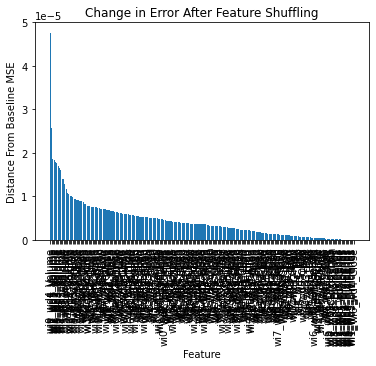

In [8]:
feature_importance(model, x_test, y_test, x_names)

In [9]:
name_sets = []
trials = 50
shared = []
all_shared = set()

for _ in range(trials):
    x_train, x_test, y_train, y_test = train_test_split(x, y)
    model = create_model()
    model.fit(x_train, y_train)
    name_sets.append(set(feature_importance(model, x_test, y_test, x_names, graph=False)))

all_shared = set(name_sets[0])
for i in range(trials):
    for j in range(i + 1, trials):
        cection = name_sets[i] & name_sets[j]
        shared.append(len(cection))
        all_shared = all_shared & cection

print(all_shared)
np.mean(shared)

KeyboardInterrupt: 

## Imact of number of weeks on model loss
- Next it would be interesting to see what impact the number of weeks a model is trained on has on its loss

In [3]:
from BackTester import BackTester
from Daily_Preprocessor import Daily_Preprocessor
from Company_Lister import Company_Lister
from Models import LSTM_Operator, RF_Operator
import hyperopt as hp
import datetime

## Tests the number of weeks to backtest

In [10]:
def run_backtester(n_weeks, retrain_weeks, tickers):
    modeler = RF_Operator(buy_cut = 1.005, short_cut = 0.995)
    bt = BackTester(
        tickers,
        preprocessor=Daily_Preprocessor,
        initial_value=100000,
        num_weeks=780,
        mod_op=modeler,
        rescrape=True,
        train_weeks=n_weeks,
        end_date='2007-01-01',
        train_every=retrain_weeks
    )
    return bt
    
test_train_weeks = [int(w) for w in np.linspace(1, 40, 10)]
returns = np.full((len(test_train_weeks),), 0.0)
tickers = np.random.choice(Company_Lister().get_snp(), size=80, replace=False)
_, tickers = run_backtester(1, None, tickers).backtest()
use_tickers = np.random.choice(tickers, size=min(len(tickers), 20), replace=False)
for i, t in enumerate(test_train_weeks):
    returns[i], valid_tkr = run_backtester(t, 200, use_tickers).backtest()

    

Processing EBAY
Not enough data to backtest EBAY
Processing IDXX
Processing LRCX
Processing JBHT
Processing FOX
Not enough data to backtest FOX
Processing IQV
Not enough data to backtest IQV
Processing MPC
Not enough data to backtest MPC
Processing SBAC
Not enough data to backtest SBAC
Processing BA
Processing NWSA
Not enough data to backtest NWSA
Processing AAP
Not enough data to backtest AAP
Processing XOM
Processing INFO
Not enough data to backtest INFO
Processing IT
Not enough data to backtest IT
Processing QRVO
Not enough data to backtest QRVO
Processing CSCO
Processing DPZ
Not enough data to backtest DPZ
Processing PNC
Processing CARR
Not enough data to backtest CARR
Processing GE
Processing NOC
Processing EW
Not enough data to backtest EW
Processing TXN
Processing INTU
Not enough data to backtest INTU
Processing ROL
Processing LVS
Not enough data to backtest LVS
Processing EVRG
Processing TPR
Not enough data to backtest TPR
Processing A
Not enough data to backtest A
Processing P

In [11]:
print(returns)

[0.65776696 0.60984366 0.65666984 0.77747481 0.81947306 0.75164882
 0.78794067 0.84765759 0.89510101 0.95873577]


In [12]:
n_trials = 5
week_arr = [int(x) for x in np.linspace(3, 100, 10)]
mses = np.full((len(week_arr), n_trials), 0.0)
hls = np.full(mses.shape, 0.0)
for i, week in enumerate(week_arr):
    print()
    print('Analyzing week', week)
    x, y, x_names, purchase_price, buy_date, sell_date = \
        Daily_Preprocessor('AAPL').produce_ind_and_response(n_weeks=week)
    means = []
    prog = 0
    for j in range(n_trials):
        cur_prog = j / n_trials // 0.05
        if cur_prog > prog:
            prog = cur_prog
            print('*', end='')
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        model = create_model()
        model.fit(x_train, y_train)
        pred = model.predict(x_test)
        mses[i, j] = ((pred - y_test) ** 2).mean()
        hls[i, j] = ((pred >= 1) & (y_test >= 1) | (pred < 1) & (y_test < 1)).mean()

mse_means = mses.mean(axis=1)
hl_means = hls.mean(axis=1)
        


Analyzing week 3
****
Analyzing week 13
****
Analyzing week 24
****
Analyzing week 35
****
Analyzing week 46
****
Analyzing week 56
****
Analyzing week 67
****
Analyzing week 78
****
Analyzing week 89
****
Analyzing week 100
****

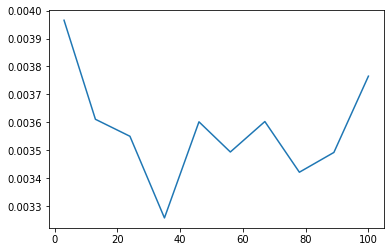

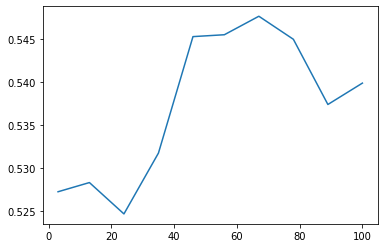

In [13]:
fig, ax = plt.subplots()
ax.plot(week_arr, mse_means)

fig, ax = plt.subplots()
ax.plot(week_arr, hl_means)

Text(0, 0.5, 'Proportion of principle')

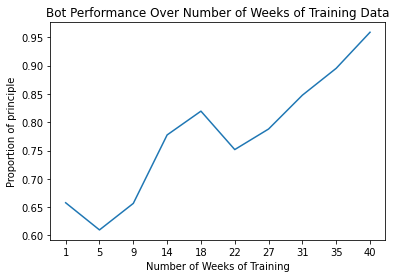

In [7]:
week_results = '0.65776696 0.60984366 0.65666984 0.77747481 0.81947306 0.75164882  0.78794067 0.84765759 0.89510101 0.95873577'
week_results = np.array([float(a) for a in week_results.split()])
fig, ax = plt.subplots()
ax.plot(np.arange(len(week_results)), week_results)
ax.set_title('Bot Performance Over Number of Weeks of Training Data')
ax.set_xticks(np.arange(len(week_results)))
ax.set_xticklabels([int(x) for x in np.linspace(1, 40, 10)])
ax.set_xlabel('Number of Weeks of Training')
ax.set_ylabel('Proportion of principle')